In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
import os
import multiprocessing

# Import Data

In [2]:
# URLs converted to raw format for direct loading
url_feature = 'https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/df_feature_sup.csv'
url_label = 'https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/training_regime_labels.csv'

# Load the feature dataset
# Using index_col=0 to ensure the 'Date' remains the index for alignment
df_feature_sup = pd.read_csv(url_feature, index_col=0, parse_dates=True)

# Load the regime labels as the training target set
df_labels_train = pd.read_csv(url_label, index_col=0, parse_dates=True)

In [3]:
df_feature_sup.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2016-01-01 to 2025-12-01
Data columns (total 27 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   SET_return                                   120 non-null    float64
 1   SET_lag_1                                    120 non-null    float64
 2   SET_lag_2                                    120 non-null    float64
 3   SET_lag_3                                    120 non-null    float64
 4   SET_lag_4                                    120 non-null    float64
 5   SET_lag_5                                    120 non-null    float64
 6   SET_lag_6                                    120 non-null    float64
 7   SET_lag_7                                    120 non-null    float64
 8   SET_lag_8                                    120 non-null    float64
 9   SET_lag_9                                    120 non-null

In [4]:
df_labels_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 2016-01-01 to 2022-12-01
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Regime        84 non-null     int64 
 1   Regime_Label  84 non-null     object
dtypes: int64(1), object(1)
memory usage: 2.0+ KB


# Train-test split

In [5]:
# 1. Split features chronologically
# 2. Select columns from index 1 to the end to exclude current 'SET_return'
X_train = df_feature_sup.loc['2016':'2022'].iloc[:, 1:]
X_test = df_feature_sup.loc['2023':'2025'].iloc[:, 1:]

# 3. Align the target array (Labels 2016-2022)
y_train = df_labels_train['Regime']

print(f"X_train shape (2016-2022): {X_train.shape}")
print(f"X_test shape  (2023-2025): {X_test.shape}")
print(f"y_train shape (2016-2022): {y_train.shape}")

# Double-check: The first column should NO LONGER be the current return
print("\nFirst 5 features in X_train:")
print(X_train.columns[:5].tolist())

X_train shape (2016-2022): (84, 26)
X_test shape  (2023-2025): (36, 26)
y_train shape (2016-2022): (84,)

First 5 features in X_train:
['SET_lag_1', 'SET_lag_2', 'SET_lag_3', 'SET_lag_4', 'SET_lag_5']


# XGBoost training

## Hyperparameter Tuning

In [6]:
logical_cores = os.cpu_count()
usable_cores = multiprocessing.cpu_count()

print(f"--- System Resource Check ---")
print(f"Total Logical Cores: {logical_cores}")
print(f"Total Usable Cores:   {usable_cores}")

--- System Resource Check ---
Total Logical Cores: 8
Total Usable Cores:   8


In [18]:
%%timeit -n 1 -r 1
# 1. Expanded Grid
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.1, 0.08, 0.05],
    'subsample': [0.8, 0.9],
    'min_child_weight': [1, 3, 5],
    'reg_lambda': [1, 10, 50],
    'colsample_bytree': [0.8],
    'gamma': [0.5]
}

# 2. XGBoost setup for 8-core CPU
xgb_base = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    tree_method='hist',
    random_state=42,
    eval_metric='mlogloss',
    n_jobs=-1                         # Parallelizes across all 8 cores
)

# 3. Setup GridSearchCV (4,320 total fits)
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# 4. Fit the model
grid_search.fit(X_train, y_train)

# 5. Assign the best estimator
best_xgb_model = grid_search.best_estimator_

print(f"\nBest CV Accuracy: {grid_search.best_score_:.4f}")
print(f"Best Parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 864 candidates, totalling 4320 fits

Best CV Accuracy: 0.7853
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 300, 'reg_lambda': 1, 'subsample': 0.8}
1min 27s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Fit the model with best parameters
Fitting 5 folds for each of 864 candidates, totalling 4320 fits

Best CV Accuracy: 0.7853

Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 300, 'reg_lambda': 1, 'subsample': 0.8}

1min 27s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

In [19]:
# 1. Initialize the finalized XGBoost with the winning parameters
best_xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    tree_method='hist',
    colsample_bytree=0.8,
    gamma=0.5,
    learning_rate=0.1,
    max_depth=2,
    min_child_weight=5,
    n_estimators=300,
    reg_lambda=1,
    subsample=0.8,
    random_state=42,
    eval_metric='mlogloss',
    n_jobs=-1  # Utilize all 8 cores for this final fit
)

# 2. Fit the model on the full 2016-2022 dataset
best_xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=0.5,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1, num_class=3, ...)

In [21]:
# 1. Generate predictions for the training set
y_train_pred = best_xgb_model.predict(X_train)

# 2. Print Classification Report
# This shows Precision, Recall, and F1-score for each regime
target_names = ['sw (0)', 'bull (1)', 'bear (2)']
print("XGBoost Training Performance (2016-2022)")
print(classification_report(y_train, y_train_pred, target_names=target_names))

XGBoost Training Performance (2016-2022)
              precision    recall  f1-score   support

      sw (0)       1.00      1.00      1.00        25
    bull (1)       1.00      1.00      1.00        24
    bear (2)       1.00      1.00      1.00        35

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



# Label prediction for test data

In [23]:
# 1. Generate class predictions (0=sw, 1=bull, 2=bear)
oos_predictions = best_xgb_model.predict(X_test)

# 2. Generate predicted probabilities for each regime
oos_probabilities = best_xgb_model.predict_proba(X_test)

# 3. Create a combined DataFrame for analysis
df_oos_results = pd.DataFrame(oos_probabilities, columns=['prob_sw', 'prob_bull', 'prob_bear'], index=X_test.index)
df_oos_results['predicted_regime'] = oos_predictions

# 4. Display the first few months of the 2023 prediction
print("Out-of-Sample Regime Predictions (2023-2025)")
print(df_oos_results.head())

Out-of-Sample Regime Predictions (2023-2025)
             prob_sw  prob_bull  prob_bear  predicted_regime
Date                                                        
2023-01-01  0.059753   0.083849   0.856398                 2
2023-02-01  0.069972   0.054078   0.875951                 2
2023-03-01  0.041682   0.094148   0.864170                 2
2023-04-01  0.182388   0.045662   0.771949                 2
2023-05-01  0.034962   0.127808   0.837230                 2


In [24]:
df_oos_results.predicted_regime.value_counts()

,count
predicted_regime,
2,36


# Visualization

In [34]:
# URL for the specific SET price dataset
url_price = 'https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/SET_price.csv'

# 1. Load and Clean
df_price = pd.read_csv(url_price)
df_price = df_price.drop([0, 1]).reset_index(drop=True)
df_price.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

# 2. Format Types
df_price['Date'] = pd.to_datetime(df_price['Date'])
df_price.set_index('Date', inplace=True)

cols_to_convert = ['Close', 'High', 'Low', 'Open', 'Volume']
for col in cols_to_convert:
    df_price[col] = pd.to_numeric(df_price[col], errors='coerce')

# 3. Filter from 2016-01-01 to the end
df_price = df_price.loc['2016-01-01':]

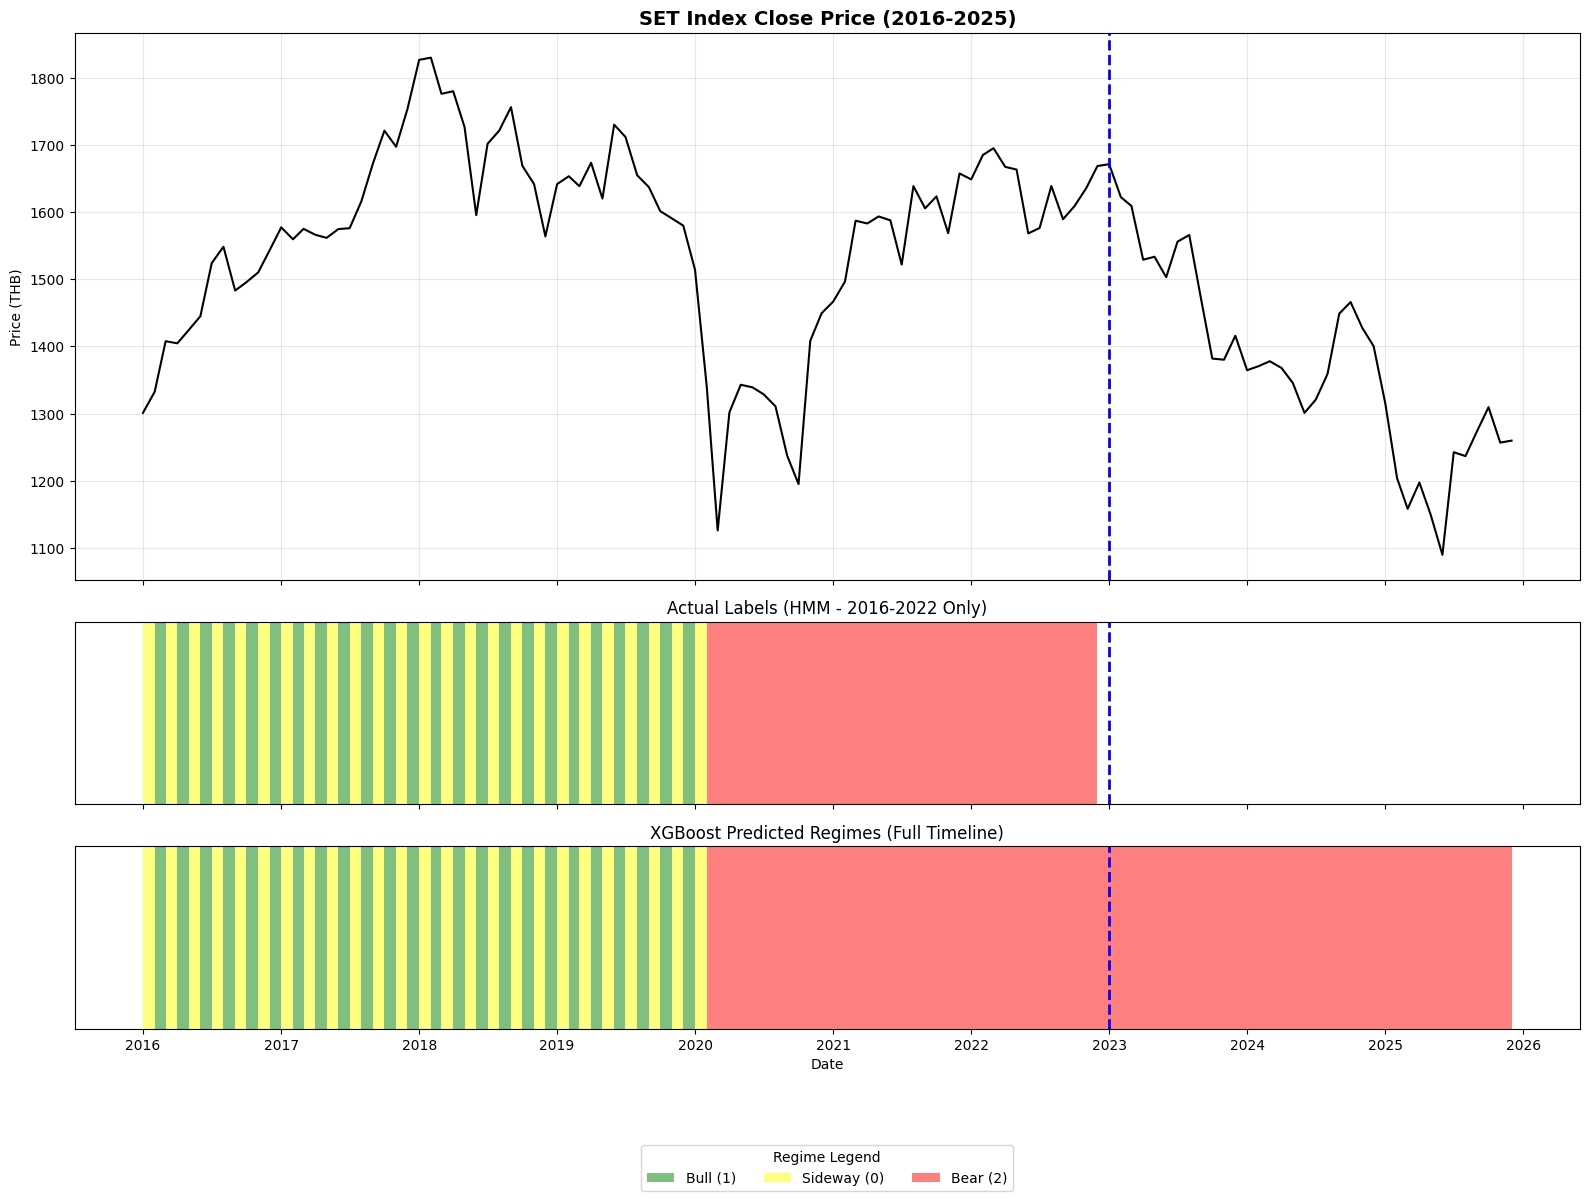

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch

# 1. Prepare Prediction Data
y_train_pred = best_xgb_model.predict(X_train)
y_test_pred = best_xgb_model.predict(X_test)

# Combine predictions into a single timeline with the index
preds_all = pd.concat([
    pd.Series(y_train_pred, index=X_train.index),
    pd.Series(y_test_pred, index=X_test.index)
]).sort_index()

# Actual labels (y_train only)
actual_labels = pd.Series(y_train, index=X_train.index).sort_index()

# 2. Setup Plotting Parameters
regime_colors = {0: 'yellow', 1: 'green', 2: 'red'}
split_date = pd.Timestamp('2023-01-01')

# Create 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12), sharex=True,
                                     gridspec_kw={'height_ratios': [3, 1, 1]})

# --- Row 1: SET Index Close Price ---
ax1.plot(df_price.index, df_price['Close'], color='black', linewidth=1.5)
ax1.set_title('SET Index Close Price (2016-2025)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Price (THB)')
ax1.grid(True, alpha=0.3)

# --- Row 2: Actual Labels (HMM Ground Truth) ---
# We use axvspan for each date segment
for i in range(len(actual_labels) - 1):
    ax2.axvspan(actual_labels.index[i], actual_labels.index[i+1],
                color=regime_colors[actual_labels.iloc[i]], alpha=0.5, lw=0)
ax2.set_title('Actual Labels (HMM - 2016-2022 Only)', fontsize=12)
ax2.set_yticks([])

# --- Row 3: Predicted Labels (XGBoost) ---
for i in range(len(preds_all) - 1):
    ax3.axvspan(preds_all.index[i], preds_all.index[i+1],
                color=regime_colors[preds_all.iloc[i]], alpha=0.5, lw=0)
ax3.set_title('XGBoost Predicted Regimes (Full Timeline)', fontsize=12)
ax3.set_yticks([])
ax3.set_xlabel('Date')

# --- Shared Formatting & Legend ---
for ax in [ax1, ax2, ax3]:
    ax.axvline(split_date, color='blue', linestyle='--', linewidth=2)

# Custom Legend
legend_elements = [
    Patch(facecolor='green', alpha=0.5, label='Bull (1)'),
    Patch(facecolor='yellow', alpha=0.5, label='Sideway (0)'),
    Patch(facecolor='red', alpha=0.5, label='Bear (2)')
]
ax3.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.6),
           ncol=3, title='Regime Legend')

plt.tight_layout()
plt.show()

In [55]:
df_price.loc['2022-12-01':]['Close'].pct_change().describe()

,Close
count,36.000000
mean,-0.006941
std,0.041930
min,-0.084275
25%,-0.036667
50%,-0.005935
75%,0.012733
max,0.140231


# Model Export

In [57]:
import joblib

# Exporting the trained model with a short filename
model_name = 'xgb_regime.joblib'
joblib.dump(best_xgb_model, model_name)

print(f"Model saved as: {model_name}")

# Use this to download the file to your local computer
from google.colab import files
files.download(model_name)

Model saved as: xgb_regime.joblib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>